#### Project : 퀀텀컴퓨팅(QUBT) 주가 예측

/tmp/ipykernel_23486/1130001953.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price = data['Close'][-1]  # 현재 가격 (2025-03-03 기준 약 7.8 USD)
/tmp/ipykernel_23486/1130001953.py:66: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


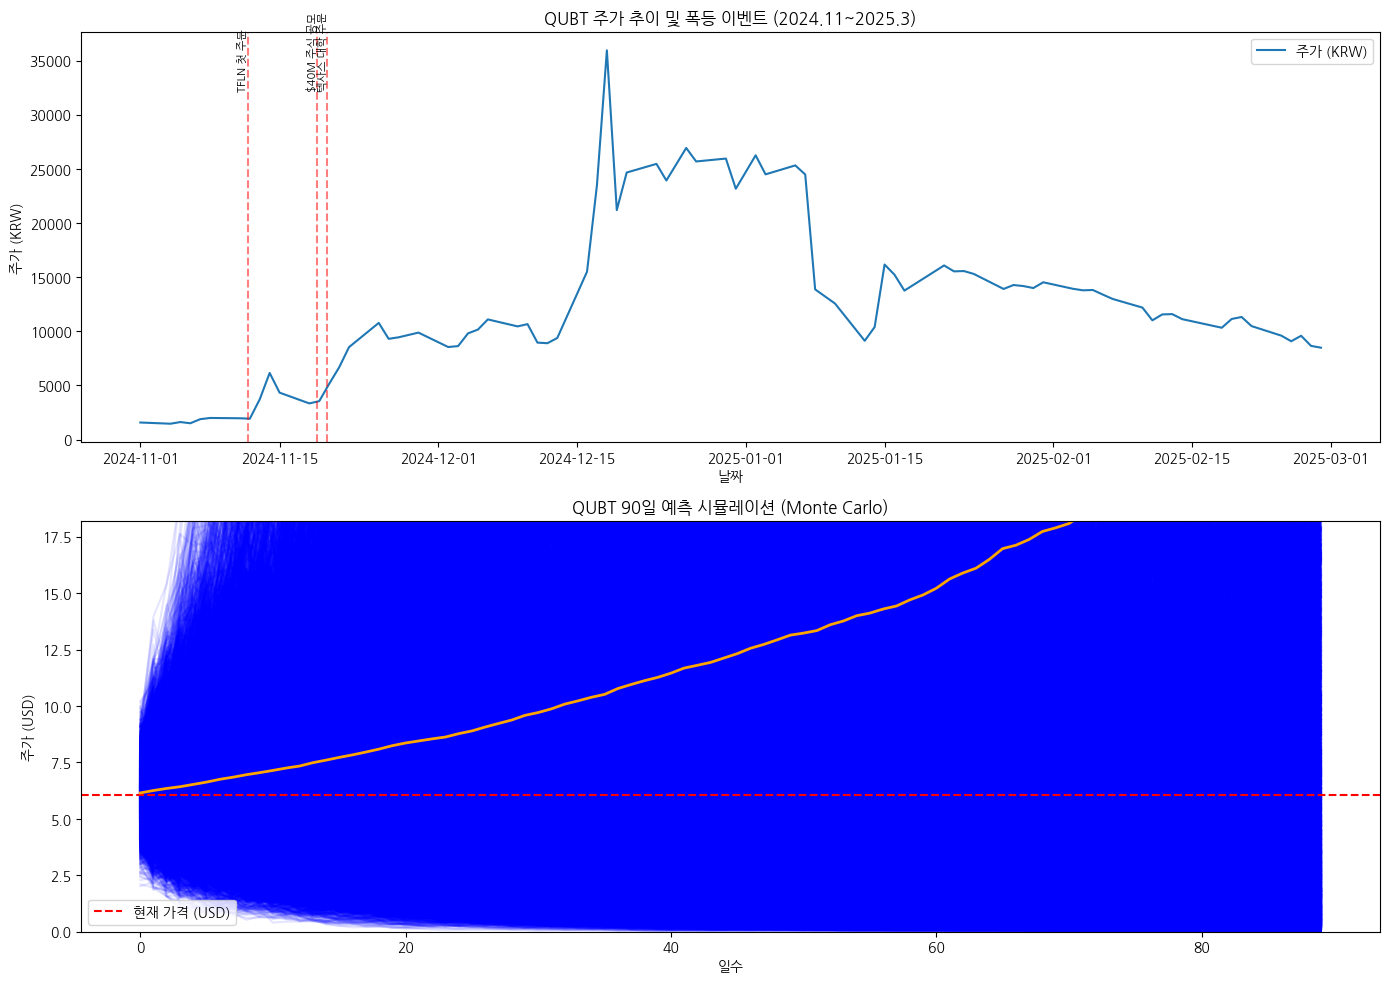

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 주가 데이터 가져오기 (달러 기준)
stock = yf.Ticker("QUBT")
data = stock.history(start="2024-11-01", end="2025-03-03")

# 원화로 변환 (환율 1400원/USD 가정)
data['Close_KRW'] = data['Close'] * 1400

# 폭등 이벤트 추가
events = {
    "2024-11-12": "TFLN 첫 주문",
    "2024-11-19": "$40M 주식 공모",
    "2024-11-20": "텍사스 대학 주문"
}

# Monte Carlo 시뮬레이션 (수정)
days = 90
simulations = 10000
last_price = data['Close'][-1]  # 현재 가격 (2025-03-03 기준 약 7.8 USD)

# 최근 3개월 데이터만 사용 (2024-12-01~2025-03-03)
recent_data = data[data.index >= '2024-12-01']
returns = recent_data['Close'].pct_change().dropna()
mean_return = returns.mean()
volatility = returns.std()

daily_returns = np.random.normal(mean_return, volatility, (days, simulations))
price_paths = np.zeros((days, simulations))
for t in range(simulations):
    price_paths[:, t] = last_price * np.cumprod(1 + daily_returns[:, t])

# 시각화
plt.figure(figsize=(14, 10))  # 그래프 크기 확대

# 과거 주가 (원화)
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Close_KRW'], label="주가 (KRW)")
for date, event in events.items():
    plt.axvline(pd.to_datetime(date), color='r', linestyle='--', alpha=0.5)
    plt.text(pd.to_datetime(date), data['Close_KRW'].max() * 0.9, event, rotation=90, fontsize=8, ha='right')
plt.title("QUBT 주가 추이 및 폭등 이벤트 (2024.11~2025.3)")
plt.xlabel("날짜")
plt.ylabel("주가 (KRW)")
plt.legend()

# 예측 시뮬레이션 (달러 기준)
plt.subplot(2, 1, 2)
plt.plot(price_paths, color='blue', alpha=0.1)
plt.axhline(y=last_price, color='r', linestyle='--', label="현재 가격 (USD)")
plt.ylim(0, max(last_price * 3, 15))  # y축 범위 0~23.4 USD로 제한
plt.title("QUBT 90일 예측 시뮬레이션 (Monte Carlo)")
plt.xlabel("일수")
plt.ylabel("주가 (USD)")
plt.legend()
plt.plot(price_paths.mean(axis=1), color='orange', linewidth=2, label="평균 예측")

plt.tight_layout()
plt.show()

#### Monte Carlo로 사용 결과
- Monte Carlo 시뮬레이션 처음에는 1000개 , 두번째 10000개 1000개의 데이터는 파란색 실선들이 무수히 많아 10000개로 증폭
- 결과는 그래프에 빼곡히 페이트 처럼 칠해져 구름처럼 보임(실선 하나당 시나리오 1개)
- 단순 Monte Carlo로만으로는 과거의 시나리오를 조합하여 가능성만 나타내기 때문에 주가를 예측하기 어려움 
- 즉, 변수는 무한히 존재할 수 있는 "이론적 가능성"을 반영하지만, 실제로는 데이터와 모델의 한계에 의해 제한
- 너무 많은 시나리오를 생성시 "독립적인 변수"가 추가되지 않고 기존 패턴의 반복이 될 가능성이 큼
- 즉 파란 구름 처럼 보이는 이유 독립적인 변수 추가가 아닌 기존 패턴이 반복되어 밀집도가 높아진 현상

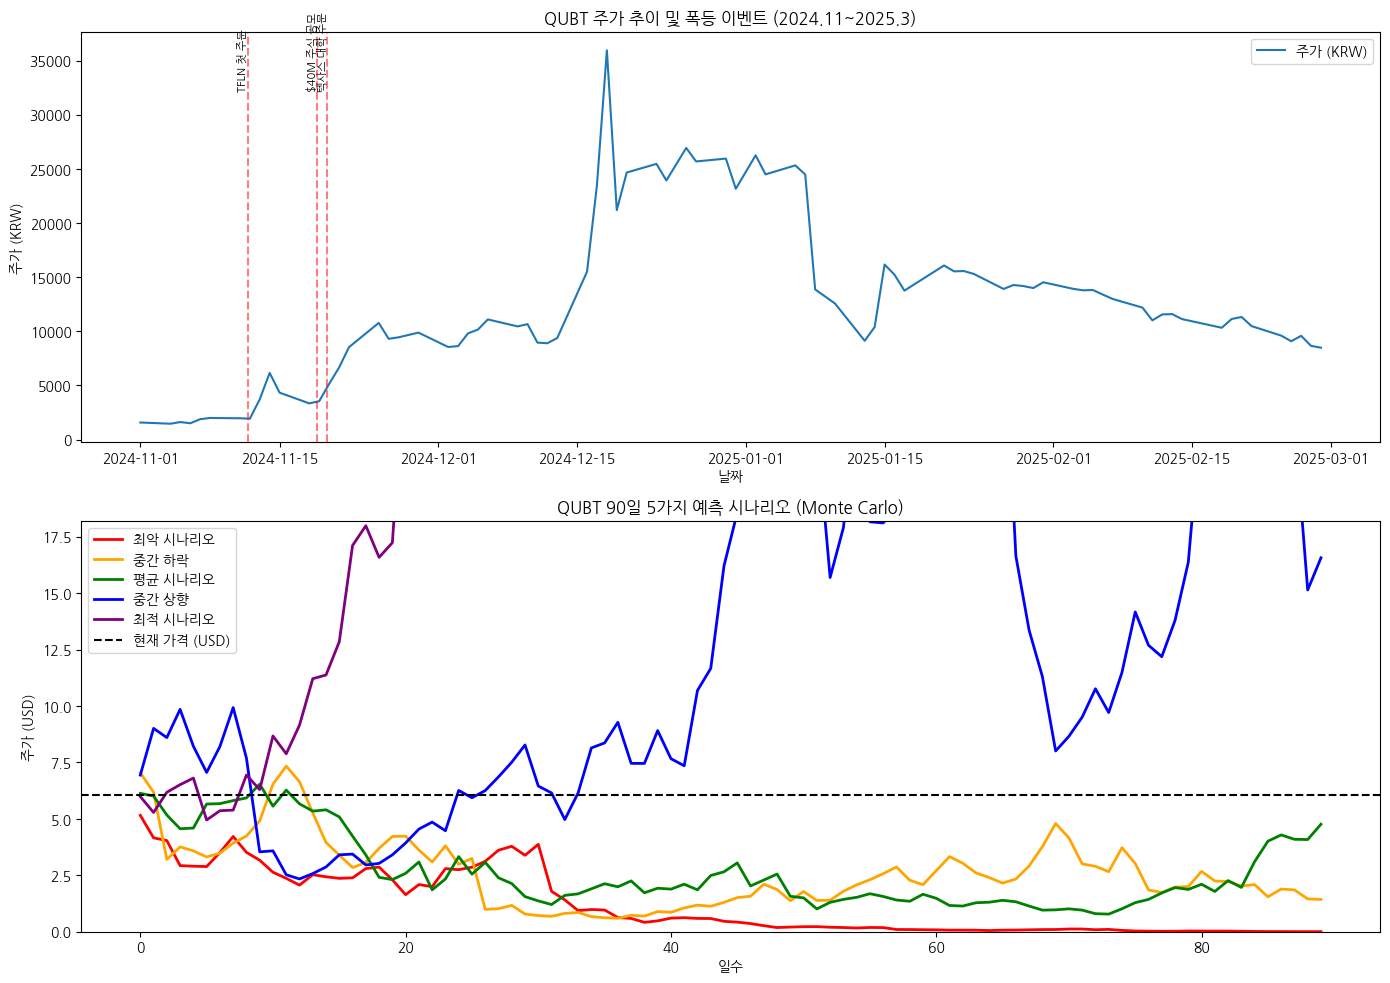

In [ ]:
# 10,000개 시나리오 생성
daily_returns = np.random.normal(mean_return, volatility, (days, simulations))
price_paths = np.zeros((days, simulations))
for t in range(simulations):
    price_paths[:, t] = last_price * np.cumprod(1 + daily_returns[:, t])

# 5가지 대표 시나리오 선택
final_prices = price_paths[-1, :]  # 90일 후 각 시나리오의 가격
sorted_indices = np.argsort(final_prices)  # 가격 기준으로 정렬

# 5가지 시나리오: 최악, 하락, 평균, 상향, 최적
scenario_indices = [
    sorted_indices[0],  # 최악 (최저 가격)
    sorted_indices[int(simulations * 0.25)],  # 하락 (하위 25%)
    sorted_indices[int(simulations * 0.5)],  # 평균 (중앙값)
    sorted_indices[int(simulations * 0.75)],  # 상향 (상위 25%)
    sorted_indices[-1]  # 최적 (최고 가격)
]

scenario_labels = ["최악 시나리오", "중간 하락", "평균 시나리오", "중간 상향", "최적 시나리오"]

# 시각화
plt.figure(figsize=(14, 10))

# 과거 주가 (원화)
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Close_KRW'], label="주가 (KRW)")
for date, event in events.items():
    plt.axvline(pd.to_datetime(date), color='r', linestyle='--', alpha=0.5)
    plt.text(pd.to_datetime(date), data['Close_KRW'].max() * 0.9, event, rotation=90, fontsize=8, ha='right')
plt.title("QUBT 주가 추이 및 폭등 이벤트 (2024.11~2025.3)")
plt.xlabel("날짜")
plt.ylabel("주가 (KRW)")
plt.legend()

# 5가지 미래 시나리오 (달러 기준)
plt.subplot(2, 1, 2)
colors = ['red', 'orange', 'green', 'blue', 'purple']
for i, idx in enumerate(scenario_indices):
    plt.plot(price_paths[:, idx], color=colors[i], label=scenario_labels[i], linewidth=2)
plt.axhline(y=last_price, color='black', linestyle='--', label="현재 가격 (USD)")
plt.ylim(0, max(last_price * 3, 15))  # y축 범위 0~23.4 USD로 제한
plt.title("QUBT 90일 5가지 예측 시나리오 (Monte Carlo)")
plt.xlabel("일수")
plt.ylabel("주가 (USD)")
plt.legend()
plt.tight_layout()
plt.show()

#### 예측시나리오 5가지로 축약 결과
- 가능성을 5가지로 좁히긴 했으나 실행 할때 마다 바뀌는 그래프 및 비현실적인 그래프 발생
- 다른 모델 적용필요